# Definições
Esse notebook irá analisar dados da estação A419, na cidade de Poço Verde, em Sergipe, de 2008 a 2023. O propósito aqui é realizar o EDA dos dados e, como output, obter alguams conclusões.

### Possíveis análises:
- Medir o nivel de radiação por ano, mes e horário do dia;
- Confirmar se há relação entre as categorias criadas (hue) com a radiação;
- Verificar estatísticas básicas (quantidades de nulls, media, desvio padrão, etc);
- Remoção de colunas desnecessárias;
- Feature engineering (juntar dois campos, criar campos category, etc)
- Remoção de Outliers

### Import das bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.special import expit
from scipy.stats import zscore
from pandas.errors import SettingWithCopyWarning
import os
from os import listdir
from os import system

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

### Métodos auxiliares

In [2]:
def getSigmoid():
    arr = np.arange(0, 1, 0.02)
    np.hstack(np.vstack(arr))
    def sigmoid(x):
        return 1/(1+expit(-x))
    
    sigmoid(arr)
    sns.scatterplot(x=arr, y=sigmoid(arr))

def get_files(n=1, lazy=True):
    cwd = os.getcwd()
    
    dict_data = {}
    
    list_files = [x for x in listdir(cwd + "/data_in_use/estacoes_solares/BDM_INMET/") if ".csv" in x]

    if n:
        _range = list_files[0:n]
    else:
        _range = list_files
    
    for i in _range:
        # print("Processando arquivo " + i)
        
        code = i.split("_")[1]
        head = os.popen("head -10 data_in_use/estacoes_solares/BDM_INMET/" + i).read()

        if lazy:
            data = "data_in_use/estacoes_solares/BDM_INMET/"+i
        else:
            data = pd.read_csv("data_in_use/estacoes_solares/BDM_INMET/"+i, sep=";", skiprows=10)
        
        dict_data[code] = [head, data]

    return dict_data

def getDictToRenameDataFrame(list_columns):
    list_columns_new = []
    for i in list_columns: 
        list_columns_new.append(str
              .lower(i)
              .replace(" ", "_")
              . replace("(", "_")
              .replace(")", "")
              .replace("/", "")
              .replace("²", "2")
              .replace("°", "")
              .replace("%", "perc")
              .replace("._", "_")
              .replace(".", "_")
              .replace("__", "_")
              .replace("_-_", "_")
              .replace(",_", "_")
             )
    
    return dict(zip(list_columns, list_columns_new))

def renameDatasetColumns(df):
    list_columns = df.columns

    list_dict_to_rename = getDictToRenameDataFrame(list_columns)
    return df.rename(columns=list_dict_to_rename).drop(["unnamed:_22"], axis=1)

def hour_transform(n):
    if len(str(n)) == 4:
        return str(n)[0:2] + ":" + str(n)[2:] + ":00"
    elif len(str(n)) == 3:
        return "0" + str(n)[0:1] + ":" + str(n)[1:] + ":00"
    elif n == 0:
        return "00:00:00"

def create_datetime_feature(df):
    df["hora_medicao"] = df["hora_medicao"].apply(hour_transform)
    df["data_hora_str"] = df["data_medicao"] + " " + df["hora_medicao"]
    df["data_hora"] = pd.to_datetime(df["data_hora_str"])
    df["hora"] = df['data_hora'].dt.hour
    
    return df.drop(["data_hora_str", "data_medicao", "hora_medicao"], axis=1)

def create_split_date_features(df):
    df["dia"] = df["data_hora"].dt.day
    df["mes"] = df["data_hora"].dt.month
    df["ano"] = df["data_hora"].dt.year

    return df

def create_category(column, df):
    labels = ["A", "B", "C", "D"]
    classes = df.describe()[column][3:8].values

    if classes[1] == 0:
        classes[1] = classes[1]+0.1
        print("aqui")
    print(classes)
    
    return pd.cut(x = df[column],
         bins = classes,
         labels = labels,
         include_lowest = True)

def removeNulls(df, col):
    return df[df[col].notnull()]

def pre_processing(df):
    renameDatasetColumns(df)

def load(path):
    return pd.read_csv(path, sep=";", skiprows=10)

def get_perc_nulls(df):
    return (df.isnull().sum()/(len(df)))*100

### Obtendo os dados
Por uma qestão de recursos, não foi possivel carregar todas as estações em um dicionário, por exemplo. Sendo assim, o método `get_files` tem um parâmetro que determina a condição de "lazy", ou seja, eu carrego somente os paths dos arquivos e vou carregando na memória somente o que usarei. Além disso, podemos especificar a quantidade de arquivos através do parâmetro `n`. 

In [3]:
dict_data = get_files(n=None)

In [4]:
print(dict_data.keys())

dict_keys(['A316', 'A419', 'A853', 'A372', 'A326', 'A225', 'A348', 'A207', 'A319', 'A430', 'A358', 'A440', 'A305', 'A337', 'A340', 'A204', 'B806', 'A825', 'A446', 'A338', 'A331', 'A872', 'A301', 'A350', 'A330', 'A823', 'A333', 'A322', 'A821', 'A828', 'A346', 'A318', 'A349', 'A336', 'A343', 'A441', 'A308', 'A220', 'A411', 'A313', 'A846', 'A855', 'A237', 'A820', 'A874', 'A450', 'A218', 'A405', 'A341', 'A444', 'A436', 'A811', 'A363', 'A352', 'A217', 'A351', 'A320', 'A239', 'A224', 'A449', 'A205', 'A873', 'A409', 'A221', 'A843', 'A304', 'A238', 'A812', 'A055', 'A317', 'A807', 'A357', 'A345', 'A133', 'A437', 'A310', 'A452', 'A818', 'A835', 'A203', 'A822', 'A424', 'A407', 'A365', 'A404', 'A354', 'A417', 'A455', 'A328', 'A377', 'A309', 'A438', 'A306', 'A849', 'A206', 'A359', 'A361', 'A842', 'A824', 'A307', 'A420', 'A054', 'A219', 'B803', 'A127', 'A826', 'A332', 'A375', 'A362', 'B804', 'A311', 'A414', 'A827', 'A223', 'A329', 'A423', 'A875', 'A344', 'A840', 'A819', 'A850', 'A222', 'A401', 'A324

### Renomeando as colunas

In [5]:
df = renameDatasetColumns(load(dict_data["A419"][1]))

### Showing info data

In [6]:
print(dict_data["A419"][0])

Nome: POCO VERDE
Codigo Estacao: A419
Latitude: -10.73805555
Longitude: -38.10833333
Altitude: 367.01
Situacao: Operante
Data Inicial: 2008-04-02
Data Final: 2023-09-10
Periodicidade da Medicao: Horaria




In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135360 entries, 0 to 135359
Data columns (total 22 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   data_medicao                                        135360 non-null  object 
 1   hora_medicao                                        135360 non-null  int64  
 2   precipitacao_total_horario_mm                       101458 non-null  float64
 3   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  120450 non-null  float64
 4   pressao_atmosferica_reduzida_nivel_do_mar_aut_mb    120440 non-null  float64
 5   pressao_atmosferica_max_na_hora_ant_aut_mb          120286 non-null  float64
 6   pressao_atmosferica_min_na_hora_ant_aut_mb          120286 non-null  float64
 7   radiacao_global_kjm2                                120338 non-null  float64
 8   temperatura_da_cpu_da_estacao_c                     120454 non-n

O dataset contém uma quantidade consderável de nulos. Neste caso, vamos remover os nulos com base na característica teórica mais importante, a radiação. Mas antes, vamos só ver a porcentagem de nulos por coluna.

In [8]:
get_perc_nulls(df)

data_medicao                                           0.000000
hora_medicao                                           0.000000
precipitacao_total_horario_mm                         25.045804
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb    11.015071
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb      11.022459
pressao_atmosferica_max_na_hora_ant_aut_mb            11.136229
pressao_atmosferica_min_na_hora_ant_aut_mb            11.136229
radiacao_global_kjm2                                  11.097813
temperatura_da_cpu_da_estacao_c                       11.012116
temperatura_do_ar_bulbo_seco_horaria_c                11.015071
temperatura_do_ponto_de_orvalho_c                     13.381353
temperatura_maxima_na_hora_ant_aut_c                  11.136968
temperatura_minima_na_hora_ant_aut_c                  11.136968
temperatura_orvalho_max_na_hora_ant_aut_c             13.584515
temperatura_orvalho_min_na_hora_ant_aut_c             13.584515
tensao_da_bateria_da_estacao_v          

In [9]:
df_non_null = removeNulls(df, "radiacao_global_kjm2")

### Configurando campos de data e hora.
Como a coluna `data_medicao` e `hora_medicao` estão separadas e não são do tipo date/time, precisamos criar uma coluna que seja desse tipo. 

In [10]:
df_non_null_dt = create_datetime_feature(df_non_null)
df_non_null_dt = create_split_date_features(df_non_null_dt)

### Plot inicial dos dados

In [11]:
df_non_null_dt.head().T

,44,45,46,47,48
precipitacao_total_horario_mm,0.0,0.0,0.0,0.0,0.0
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,966.9,967.6,968.0,968.7,969.2
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,1008.508833,1009.482174,1009.942722,1010.701946,1011.252573
pressao_atmosferica_max_na_hora_ant_aut_mb,966.9,967.6,968.0,968.7,969.2
pressao_atmosferica_min_na_hora_ant_aut_mb,966.6,966.9,967.5,968.0,968.7
radiacao_global_kjm2,858.116,57.528,-3.532,-3.54,-3.526
temperatura_da_cpu_da_estacao_c,29.0,27.0,25.0,25.0,24.0
temperatura_do_ar_bulbo_seco_horaria_c,25.8,24.1,23.8,23.6,23.4
temperatura_do_ponto_de_orvalho_c,21.6,21.6,22.0,22.2,22.1
temperatura_maxima_na_hora_ant_aut_c,27.2,25.8,24.1,23.8,23.6


In [12]:
df = df_non_null_dt

### Algumas estatísticas e Outliers
Uma checagem rápida das estatísticas dos dados para detectar em um primeiro momento a presença de outliers. 

In [13]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitacao_total_horario_mm,101347.0,0.067475,0.0,0.0,0.0,0.0,55.0,0.569986
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,120338.0,972.565131,961.6,970.7,972.5,974.5,981.5,2.696615
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,120328.0,1014.647659,1002.34451,1012.50009,1014.570961,1016.925705,1024.321934,3.137479
pressao_atmosferica_max_na_hora_ant_aut_mb,120176.0,972.815821,961.9,970.9,972.7,974.7,981.9,2.672098
pressao_atmosferica_min_na_hora_ant_aut_mb,120176.0,972.310832,961.5,970.4,972.2,974.3,981.4,2.707147
radiacao_global_kjm2,120338.0,797.024097,-3.54,-3.538,42.5995,1545.24475,4371.247,1065.584085
temperatura_da_cpu_da_estacao_c,120338.0,25.808099,14.0,22.0,25.0,29.0,43.0,4.526834
temperatura_do_ar_bulbo_seco_horaria_c,120338.0,24.256579,13.2,21.4,23.4,26.8,39.2,3.940426
temperatura_do_ponto_de_orvalho_c,117135.0,19.065148,7.1,17.9,19.3,20.4,28.6,1.999411
temperatura_maxima_na_hora_ant_aut_c,120175.0,24.920667,13.5,21.8,23.9,27.9,39.9,4.216606


#### Radiação
O desvio padrão da radiação está muito alto em relação a média. Vamos fazer algumas análises e tentar chegar numa conclusão.

##### Percentil

In [14]:
for i in range(0, 101):
    value_str = str(i)

    if len(value_str) == 1:
        value_str = "0.0"+value_str
    
    elif len(value_str) == 2:
        value_str = "0."+value_str
    else:
        value_str = "1.0"
    
    double_value = float(value_str) 
    print(value_str, df["radiacao_global_kjm2"].quantile(double_value))
    

0.00 -3.54
0.01 -3.54
0.02 -3.54
0.03 -3.54
0.04 -3.54
0.05 -3.54
0.06 -3.54
0.07 -3.54
0.08 -3.54
0.09 -3.54
0.10 -3.54
0.11 -3.54
0.12 -3.54
0.13 -3.54
0.14 -3.54
0.15 -3.54
0.16 -3.54
0.17 -3.54
0.18 -3.54
0.19 -3.54
0.20 -3.54
0.21 -3.54
0.22 -3.54
0.23 -3.54
0.24 -3.54
0.25 -3.538
0.26 -3.532
0.27 -3.518
0.28 -3.493
0.29 -3.471
0.30 -3.424
0.31 -3.367
0.32 -3.298159999999996
0.33 -3.219
0.34 -3.131
0.35 -3.02
0.36 -2.901
0.37 -2.764
0.38 -2.599
0.39 -2.429
0.40 -2.237
0.41 -2.007
0.42 -1.746
0.43 -1.386
0.44 -0.9557200000000011
0.45 -0.2993499999999985
0.46 2.9141000000000203
0.47 9.081119999999995
0.48 18.38159999999995
0.49 29.057259999999992
0.50 42.5995
0.51 68.15488000000006
0.52 108.86240000000032
0.53 155.44883
0.54 204.8438000000002
0.55 254.83915000000098
0.56 313.586
0.57 380.1778099999996
0.58 447.3846599999998
0.59 508.59098
0.60 566.6619999999999
0.61 622.9218799999986
0.62 685.2020200000001
0.63 753.249
0.64 825.1974000000002
0.65 895.7623500000005
0.66 965.450719999

Como vimos, mudanças significtiva nos dados ocorrem a partir do 46th percentil. Vamos agora ordenar para ver se o maior valor está muito diferentes dos próximos.

In [15]:
df.sort_values(by="radiacao_global_kjm2", ascending=False)["radiacao_global_kjm2"].head(10)

111063    4371.247
42736     4217.321
24326     4203.533
68871     4180.166
65775     4174.018
78207     4154.848
24807     4129.034
16432     4123.581
94887     4108.057
25144     4104.767
Name: radiacao_global_kjm2, dtype: float64

In [16]:
df.sort_values(by="radiacao_global_kjm2", ascending=True)["radiacao_global_kjm2"].head(10)

91630   -3.54
29432   -3.54
87816   -3.54
87815   -3.54
87814   -3.54
87800   -3.54
87799   -3.54
29431   -3.54
87796   -3.54
87794   -3.54
Name: radiacao_global_kjm2, dtype: float64

Aparentemente, não há outliers, vamos calcular o z-score para essa coluna: `Z = (X−µ) ÷ σ`

In [17]:
df[["radiacao_global_kjm2"]].apply(zscore).sort_values(by="radiacao_global_kjm2", ascending=False)

,radiacao_global_kjm2
111063,3.354252
42736,3.209799
24326,3.196860
68871,3.174931
65775,3.169161
...,...
40606,-0.751294
40586,-0.751294
94799,-0.751294
94800,-0.751294


O z-score não mostrou nada muito atipico. Vamos plotar o histograma.

<Axes: ylabel='Frequency'>

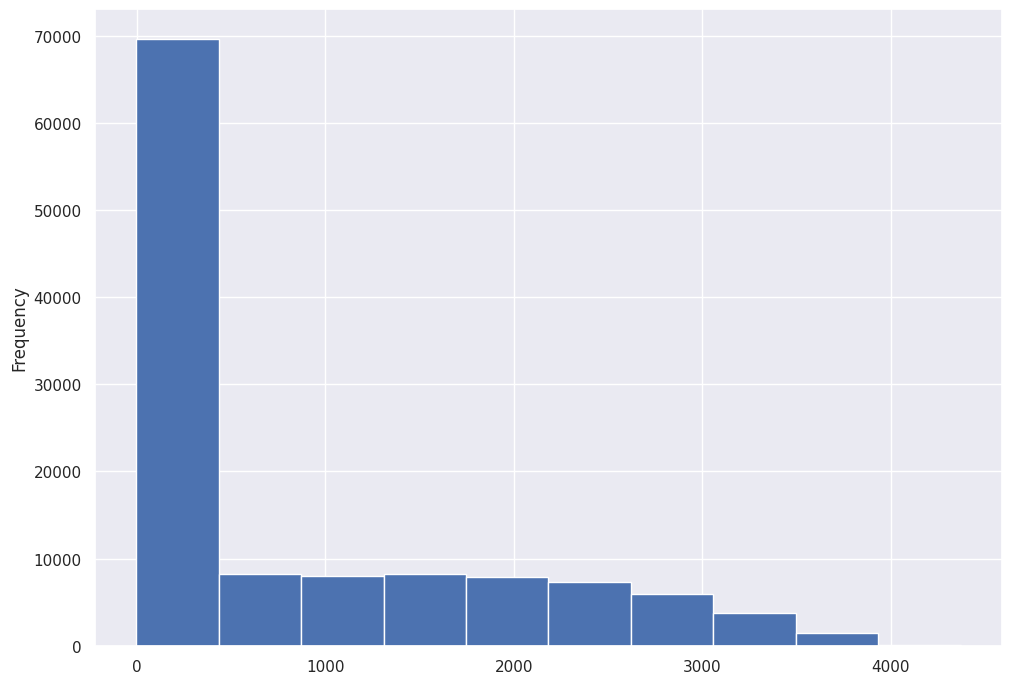

In [18]:
df["radiacao_global_kjm2"].plot.hist()

In [19]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].count()

65882

In [20]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].describe()

count    65882.000000
mean      1458.431676
std       1052.285103
min          0.002000
25%        505.376250
50%       1399.093500
75%       2300.025500
max       4371.247000
Name: radiacao_global_kjm2, dtype: float64

<Axes: ylabel='Frequency'>

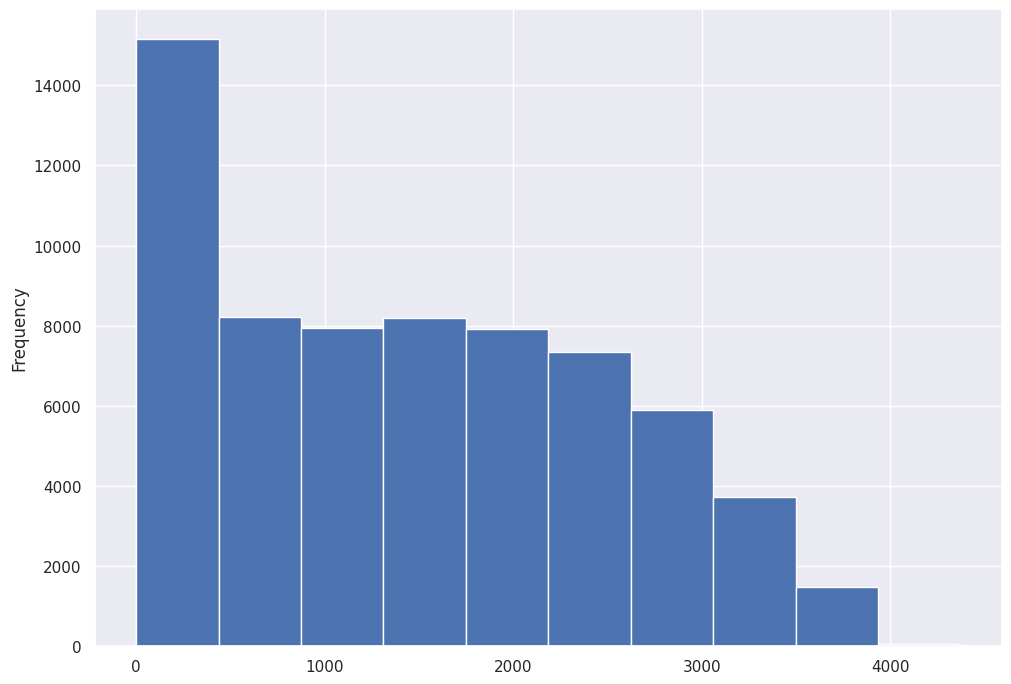

In [21]:
df[df["radiacao_global_kjm2"]>0]["radiacao_global_kjm2"].plot.hist()

Apesar do desbalanceamento dos dados, não se pode afirmar que a radiação tenha outliers. Portanto, não removeremos nenhum registro. Entretanto, podemos remover posteriormente apenas para ver o comportamento dos dados.

In [22]:
# df = df[df["radiacao_global_kjm2"]>0]

#### Vento
Aparentemente, a variável do vento contém alguns dados desbalanceados, como podemos ver aqui no histograma

<Axes: ylabel='Frequency'>

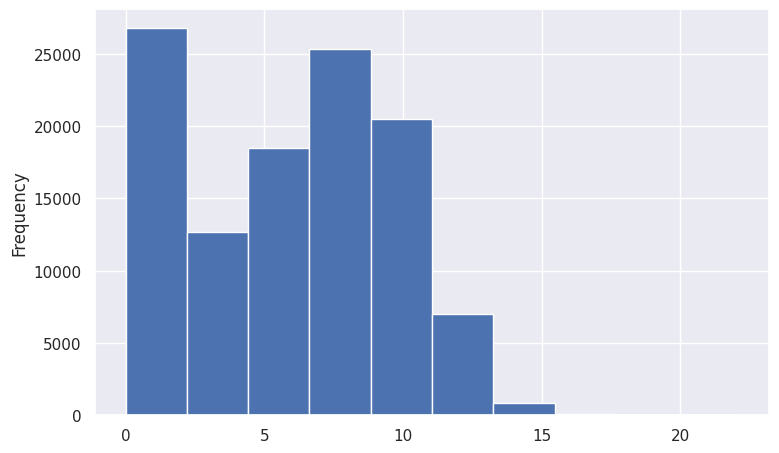

In [23]:
sns.set_theme(rc={'figure.figsize':(8.7,5.27)})
df["vento_rajada_maxima_ms"].plot.hist()

In [24]:
df[df["vento_rajada_maxima_ms"] > 15]["vento_rajada_maxima_ms"].count()

111

In [25]:
df = df[df["vento_rajada_maxima_ms"] <=15]

### Removendo colunas
A coluna `precipitacao_total_horario_mm` tem muitos zeros ou nulos, portanto, iremos remove-la.

In [26]:
df["precipitacao_total_horario_mm"].value_counts()

precipitacao_total_horario_mm
0.0     90865
0.2      2898
0.4      1004
0.6       620
0.8       475
        ...  
17.2        1
22.8        1
29.6        1
14.0        1
15.0        1
Name: count, Length: 84, dtype: int64

<Axes: ylabel='Frequency'>

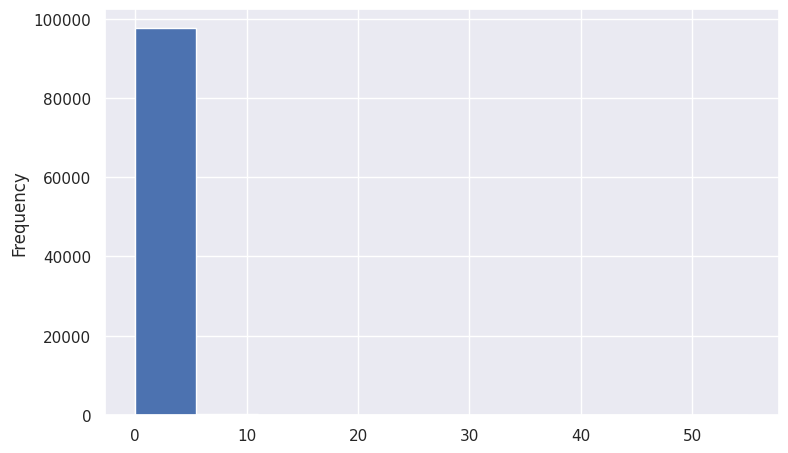

In [27]:
df["precipitacao_total_horario_mm"].plot.hist()

In [28]:
without_relevance = ["temperatura_do_ponto_de_orvalho_c",
                 "temperatura_orvalho_max_na_hora_ant_aut_c",
                 "temperatura_orvalho_min_na_hora_ant_aut_c",
                 "tensao_da_bateria_da_estacao_v",
                 "vento_direcao_horaria_gr__gr",
                 "vento_velocidade_horaria_ms"]

many_nulls_zeros = ["precipitacao_total_horario_mm"]

without_relevance.extend(many_nulls_zeros)

df = df.drop(without_relevance, axis=1)

### Feature engineering
Algumas colunas possuem comportamento similar. Portanto, podemos mescla-las em uma só. 

#### Atmo Press

In [29]:
join_press = [
            "pressao_atmosferica_ao_nivel_da_estacao_horaria_mb", 
            "pressao_atmosferica_reduzida_nivel_do_mar_aut_mb",
            "pressao_atmosferica_max_na_hora_ant_aut_mb",
            "pressao_atmosferica_min_na_hora_ant_aut_mb"
       ]
df[join_press].describe().T

,count,mean,std,min,25%,50%,75%,max
pressao_atmosferica_ao_nivel_da_estacao_horaria_mb,111535.0,972.564770,2.699047,961.80000,970.700000,972.500000,974.500000,981.500000
pressao_atmosferica_reduzida_nivel_do_mar_aut_mb,111535.0,1014.649440,3.144315,1002.34451,1012.490143,1014.581931,1016.941939,1024.321934
pressao_atmosferica_max_na_hora_ant_aut_mb,111535.0,972.817691,2.675057,961.90000,970.900000,972.700000,974.700000,981.900000
pressao_atmosferica_min_na_hora_ant_aut_mb,111535.0,972.312928,2.710098,961.70000,970.400000,972.200000,974.300000,981.400000


In [30]:
df_local =  df[join_press]
df["press_atmo"] = df_local.mean(axis=1)
df = df.drop(join_press, axis=1)

#### Temperature

In [31]:
mean_temp = [
        "temperatura_do_ar_bulbo_seco_horaria_c",
        "temperatura_da_cpu_da_estacao_c", 
        "temperatura_maxima_na_hora_ant_aut_c",
        "temperatura_minima_na_hora_ant_aut_c"]

df[mean_temp].describe().T

,count,mean,std,min,25%,50%,75%,max
temperatura_do_ar_bulbo_seco_horaria_c,111535.0,24.244767,3.959217,13.2,21.4,23.4,26.8,39.2
temperatura_da_cpu_da_estacao_c,111535.0,25.770476,4.526444,14.0,22.0,25.0,29.0,43.0
temperatura_maxima_na_hora_ant_aut_c,111534.0,24.906219,4.234369,13.5,21.8,23.9,27.8,39.9
temperatura_minima_na_hora_ant_aut_c,111534.0,23.634418,3.701327,13.0,21.1,22.9,25.9,38.9


In [32]:
df_local =  df[mean_temp]
df["temperature"] = df_local.mean(axis=1)
df = df.drop(mean_temp, axis=1)

#### Humidity

In [33]:
mean_humidity = ["umidade_rel_max_na_hora_ant_aut_perc",
            "umidade_rel_min_na_hora_ant_aut_perc",
            "umidade_relativa_do_ar_horaria_perc"]

df[mean_humidity].describe().T

,count,mean,std,min,25%,50%,75%,max
umidade_rel_max_na_hora_ant_aut_perc,109918.0,77.854018,17.470193,18.0,66.0,84.0,92.0,100.0
umidade_rel_min_na_hora_ant_aut_perc,109918.0,72.299287,19.634246,14.0,57.0,78.0,89.0,100.0
umidade_relativa_do_ar_horaria_perc,110000.0,75.167218,18.630583,17.0,61.0,82.0,90.0,100.0


In [34]:
df_local =  df[mean_humidity]
df["humidity"] = df_local.mean(axis=1)
df = df.drop(mean_humidity, axis=1)

In [35]:
df.head()

,radiacao_global_kjm2,vento_rajada_maxima_ms,data_hora,hora,dia,mes,ano,press_atmo,temperature,humidity
44,858.116,8.8,2008-04-03 20:00:00,20,3,4,2008,977.227208,26.95,76.333333
45,57.528,7.6,2008-04-03 21:00:00,21,3,4,2008,977.895544,25.25,83.333333
46,-3.532,5.8,2008-04-03 22:00:00,22,3,4,2008,978.360680,24.15,87.666667
47,-3.540,5.2,2008-04-03 23:00:00,23,3,4,2008,979.025486,24.00,91.000000
48,-3.526,4.6,2008-04-04 00:00:00,0,4,4,2008,979.588143,23.60,92.666667


### Analise com datas
Aqui iremos plotar a radiação por data

#### Ano

In [36]:
df_year = df[["ano", "radiacao_global_kjm2"]].groupby(['ano']).mean().reset_index()

#### Média e desvio
Apenas para garantir que não temos uma discrepância entre média e desvio, vamos exibir por ano. 

In [37]:
df[["ano", "radiacao_global_kjm2"]].groupby(['ano'])\
['radiacao_global_kjm2'].agg(['mean','std'])

,mean,std
ano,,
2008,740.734206,1019.663125
2009,772.911456,1057.175693
2010,767.652888,1048.961076
2011,798.622308,1062.491495
2012,811.097712,1078.430943
2013,805.539455,1086.110795
2014,763.067513,1033.913405
2015,828.016049,1111.033903
2016,798.293335,1071.376471


<Axes: xlabel='ano', ylabel='radiacao_global_kjm2'>

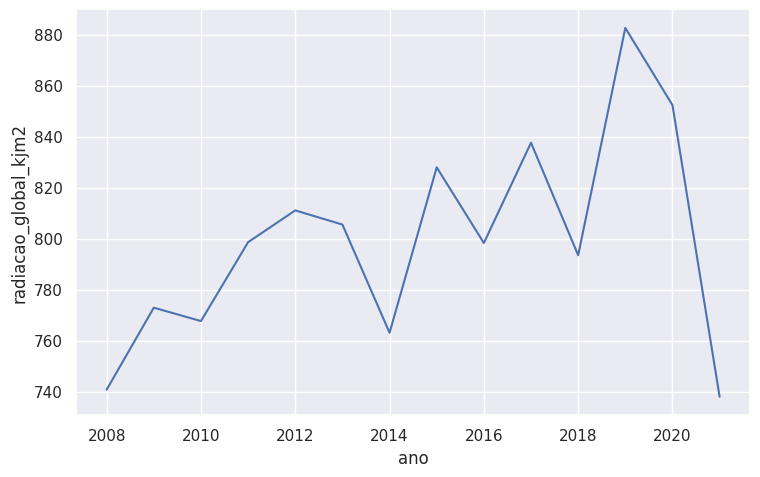

In [39]:
sns.lineplot(data=df_year, x=df_year["ano"], y=df_year["radiacao_global_kjm2"])

#### Mes

In [40]:
df_month = df[["mes", "radiacao_global_kjm2"]].groupby(['mes']).mean().reset_index()

<Axes: xlabel='mes', ylabel='radiacao_global_kjm2'>

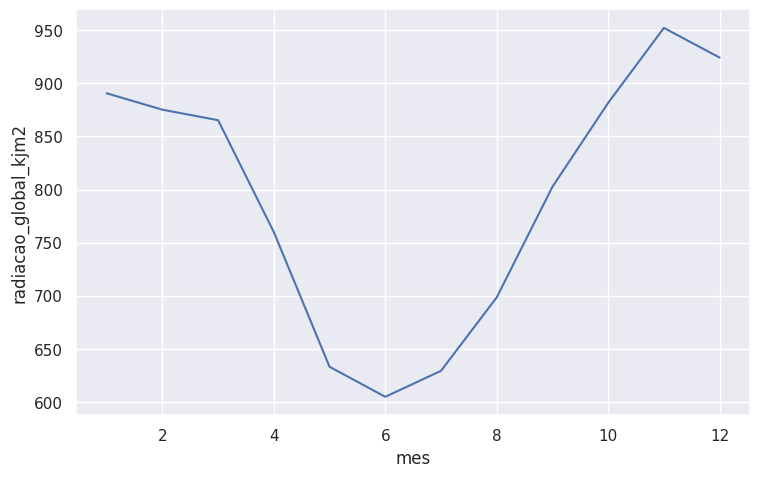

In [41]:
sns.lineplot(data=df_month, x=df_month["mes"], y=df_month["radiacao_global_kjm2"])

#### Hora

In [42]:
df_hour = df[["hora", "radiacao_global_kjm2"]].groupby(['hora']).mean().reset_index()

<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

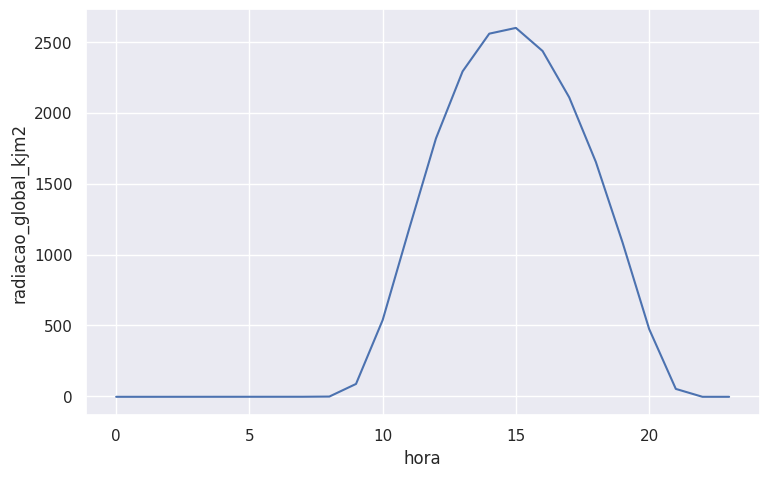

In [43]:
sns.lineplot(data=df_hour, x=df_hour["hora"], y=df_hour["radiacao_global_kjm2"])

#### Hora com o vento como `hue`

In [44]:
df_hour_wind = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "vento_rajada_maxima_ms"]]\
.fillna(0)

df_hour_wind["wind_catg"] = create_category("vento_rajada_maxima_ms", df_hour_wind)


[ 0.   2.5  6.4  8.9 15. ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

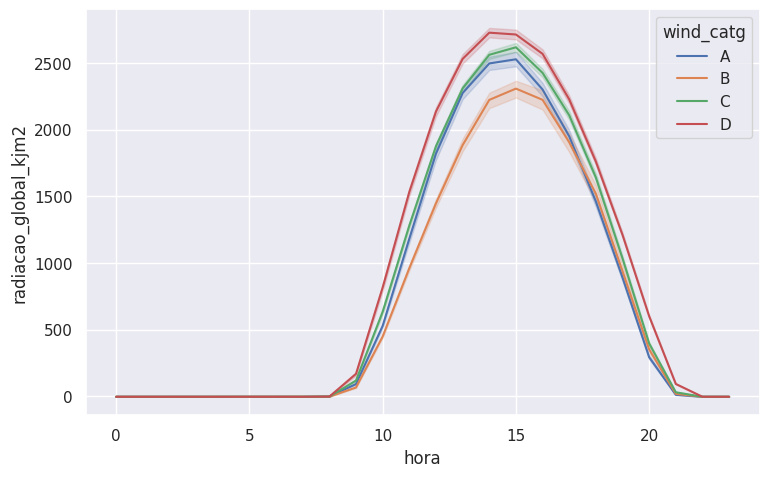

In [45]:
sns.lineplot(data=df_hour_wind, x=df_hour_wind["hora"], y=df_hour_wind["radiacao_global_kjm2"], hue=df_hour_wind["wind_catg"])

#### Hora com a pressão atmo. como `hue`

In [46]:
df_hour_press = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "press_atmo"]]\
.fillna(0)

df_hour_press["press_catg"] = create_category("press_atmo", df_hour_press)

[971.9611275  981.12922325 983.01050925 985.102435   992.13336025]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

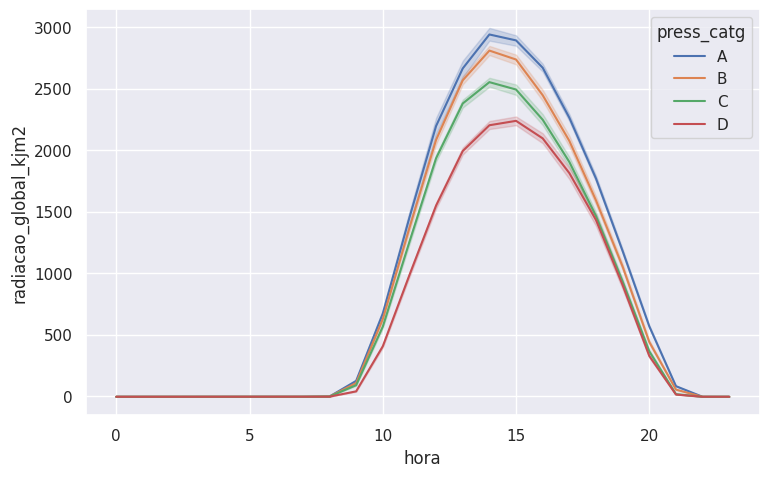

In [47]:
sns.lineplot(data=df_hour_press, x=df_hour_press["hora"], y=df_hour_press["radiacao_global_kjm2"], hue=df_hour_press["press_catg"])

#### Hora com a temperatura como `hue`

In [48]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "temperature"]]\
.fillna(0)

df_temp["temp_catg"] = create_category("temperature", df_temp)

[13.45  21.675 23.75  27.325 40.25 ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

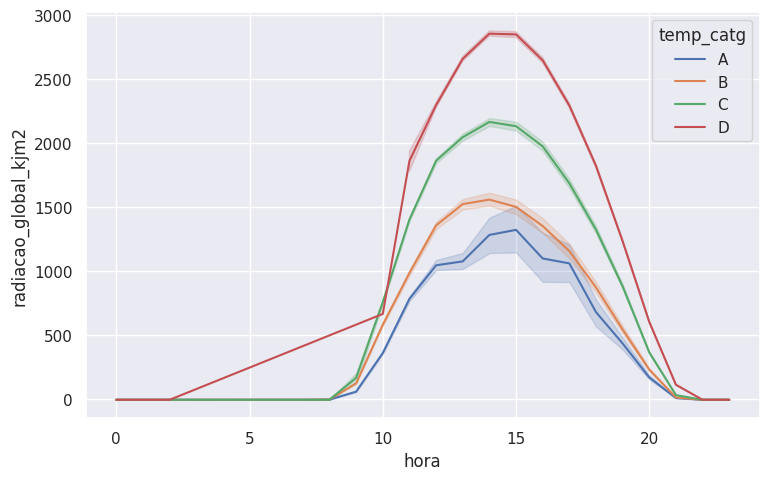

In [49]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["temp_catg"])

#### Hora com a umidade como `hue`

In [50]:
df_temp = df[[
    "hora", 
    "radiacao_global_kjm2", 
    "humidity"]]\
.fillna(0)

df_temp["hum_catg"] = create_category("humidity", df_temp)

[  0.          60.33333333  81.          90.         100.        ]


<Axes: xlabel='hora', ylabel='radiacao_global_kjm2'>

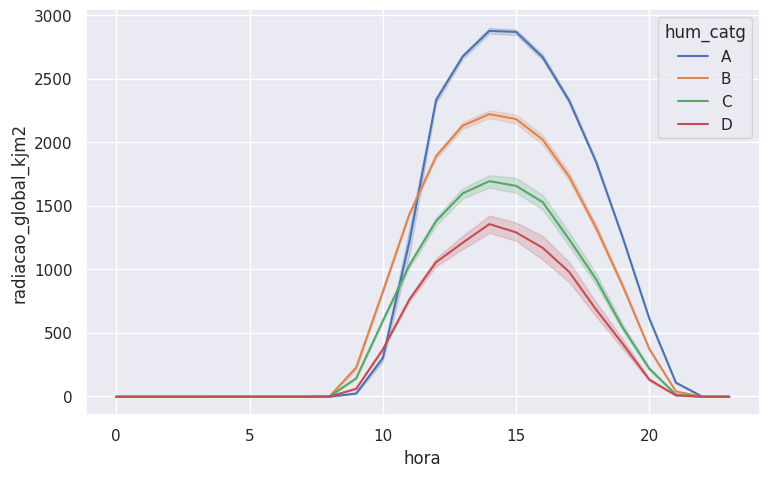

In [51]:
sns.lineplot(data=df_temp, x=df_temp["hora"], y=df_temp["radiacao_global_kjm2"], hue=df_temp["hum_catg"])

#### Relação linear entre radiação e vento 

<Axes: xlabel='vento_rajada_maxima_ms', ylabel='radiacao_global_kjm2'>

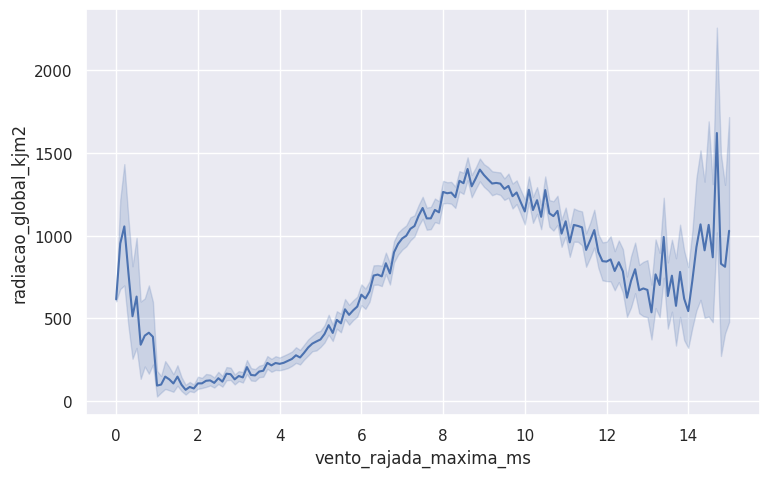

In [52]:
sns.lineplot(data=df, x=df["vento_rajada_maxima_ms"], y=df["radiacao_global_kjm2"])

<Axes: xlabel='humidity', ylabel='radiacao_global_kjm2'>

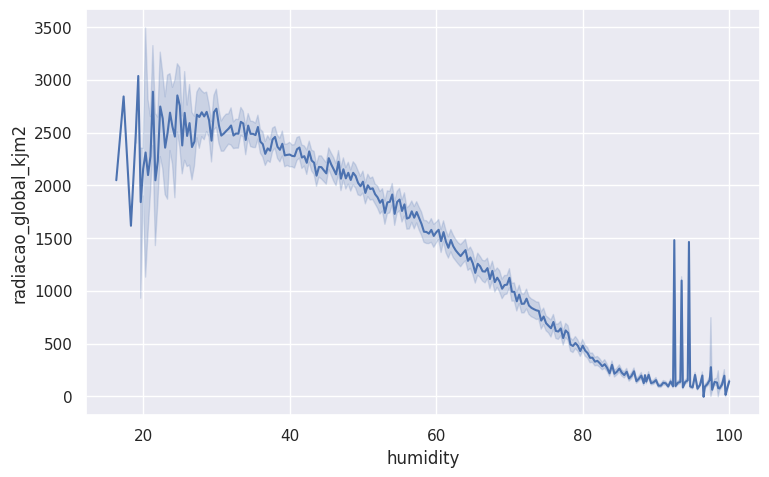

In [57]:
sns.lineplot(data=df, x=df["humidity"], y=df["radiacao_global_kjm2"])

### Conclusões

#### Desbalanceamento
O dataset possui uma quantidade razoável de nulos, quando falamos da coluna "alvo" radiação, que fica em torno de \~11%. Como não chega a ser um valor expressivo, podemos simplesmente remover os nulos dessa coluna. Em seguida, analisamos as estatisticas dos dados, como média, desvio padrão e quartis. O que foi percebido é um valor alto do desvio em relação a média, podendo indicar a presença de outliers. Entretanto, o dataset na verdade possui dados desbalanceados, tendo muitos valores negativos (~45%) na mesma faixa de valores, o que pode comppromenter uma futura previsão. Aqui podemos tratar esse desbalanceamento com algumas técnicas, como o undersampling, por exemplo. Iremos remover posteriormente, apenas para checar o comportamento dos dados quando plotamos.

Ainda falando de dados desbalanceados, temos também a categoria "vento", que contém um numero pequeno de registros acima do valor 15. Portanto, para fins de previsão, podemos remove-los.

Sobre a coluna de precipitação, temos valores zerados ou nulos quase em sua totalidade. Portanto, iremos remove-la do dataset.

#### Feature Engineering

No dataset, existem colunas que representam o mesmo conceito, e possuem medidas estatisticas (media, desvio) semelhantes. Portanto, aplicamos alguns métodos para "juntarmos" essas colunas semelhantes em uma só, como o caso das colunas de pressão atmosférica, umidade e temperatura.


#### Analise com datas

Para termos ma visão geral falando de séries temporais, agregamos os dados por ano, mes e horário, para tentar enxergar algum padrão.

##### Por ano
Agregando os dados por ano, notou-se um leve aumento, de de 2008 a 20919, com uma variação nesse período de ~16%, muito provávelmente pela questões climáticas.

##### Por mes
Construindo um gráfico com dados agregados por mes, não houve nenhum ponto atípico. Os dados mostram uma maior incidência de radiação no início do ano (verão), com uma queda acentuada assim que deslocamos a coluna temporal até o meio do ano (outuno-inverno), com novo aumento da radiação assim que se aproxima do final do ano (primavera-verão).

##### Por hora
Assim como o plot por mês, não houve nenhum comportamento atípico ao esperado, tendo a faixa ~10h-17h a maior incidência de radição do dia, caindo bruscamente a partir das 20h.

##### Valores horários por outra colunas
Nessa análise, decidimos isolar as observações horárias por categorias (A, B, C e D) dentro de algumas colunas. Ou seja, utilizamos os quartis dessas colunas e categorizamos os valores. Ex: temperatura categoria A: de 0 a 15, categoria B: de 15 a 25, e assim por diante. As seguintes colunas foram utilzadas:

- **Vento**: Percebemos uma ligeira relação diretamente proporcional entre ventos fortes e maiores niveis de radiação, porém nada relevante.
- **Pressão atmosférica**: aqui tivemos um aumento dessa relação entre uma categoria especifica (baixa pressão atmosférica) e o nivel de radiação solar.
- **Temperatura**: no caso da temperatura, não houve comportamento inesperado, prevalecendo as altas temperaturas com incidência da radiação.
- **Umidade**: da mesma forma que a temperatura, também não houve nada diferente do previsto, com as baixas taxas de umidade tendo relação forte com altos valores de radiação solar.

##### Relação linear
Como ultima análise, decidimos verificar se existe uma relação linear entre alguma coluna e os valores de radiação. Como escolha, tivemos um resultado interessante utilzando o vento novamente. O gráfico mostra que o pico de radiação é atingido quando a rajada máxima de vento fica entre 8-10 m/s, com queda acentuada ao ultrapassar esses valores. E para confirmar a relação inversamente proporcional entre umidade e a radiação, também colocamos em gráfico ambas as colunas, evidenciando esse comportamento.